In [2]:
import numpy as np 
import matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
raw_data = pd.read_csv("lca_records.csv")

In [4]:
def MisVals(raw_data):
    missing_values = raw_data.isna().sum()
    return missing_values

In [5]:
missing_values = MisVals(raw_data)
cols_min_missing = missing_values[(missing_values>0) & (missing_values<400)]
cols_names = cols_min_missing.index
cols_names

Index(['job_title', 'employer_name', 'employer_state', 'worksite_city',
       'worksite_county', 'worksite_state', 'worksite_postal_code',
       'wage_rate_of_pay_from', 'wage_unit_of_pay'],
      dtype='object')

In [6]:
raw_data = raw_data.dropna(subset= cols_names)

In [7]:
missing_values = MisVals(raw_data)
missing_values

id                                      0
case_status                             0
received_date                           0
decision_date                           0
visa_class                              0
job_title                               0
soc_code                                0
soc_title                               0
full_time_position                      0
total_worker_positions                  0
new_employment                          0
continued_employment                    0
change_previous_employment              0
new_concurrent_employment               0
change_employer                         0
amended_petition                        0
employer_name                           0
employer_city                           0
employer_state                          0
employer_postal_code                    0
employer_country                        0
employer_province                 2580764
naics_code                              0
lawfirm_name_business_name        

- __employer_province__ and __secondary_entity_bussiness_name__ has the highest number of missing values in the dataset , based on this, we can concur these are not required for our analysis and we can drop these altogether.
- __h_1b_dependent__, __secondary_entity__ and __prevailing_wage__ have moderate missing values that can be imputed with various techniques such as predictive imputation or median and mode for both columns repectively.
- __employer_state__ and __worksite_county__ have relatively few missing values, tese can be either imputed or the rows with missing values in these can be dropped since the number of missing values is relatively low.

In [8]:
cols = ['decision_date','new_employment','continued_employment','change_previous_employment','new_concurrent_employment','change_employer','amended_petition','employer_province','lawfirm_name_business_name','secondary_entity','secondary_entity_business_name','wage_rate_of_pay_from','wage_rate_of_pay_to','agree_to_lc_statement','worksite_city','worksite_county','prevailing_wage','wage_unit_of_pay','h_1b_dependent','employer_country','employer_city']
raw_data = raw_data.drop(cols,axis = 1)

In [9]:
raw_data.case_status.value_counts()

case_status
Certified                2570957
Certified - Withdrawn     137324
Withdrawn                  51357
Denied                     15354
Name: count, dtype: int64

In [10]:
raw_data = raw_data[~raw_data['case_status'].isin(['Certified - Withdrawn', 'Withdrawn'])]

In [11]:
raw_data.case_status.value_counts()

case_status
Certified    2570957
Denied         15354
Name: count, dtype: int64

In [12]:
raw_data.columns

Index(['id', 'case_status', 'received_date', 'visa_class', 'job_title',
       'soc_code', 'soc_title', 'full_time_position', 'total_worker_positions',
       'employer_name', 'employer_state', 'employer_postal_code', 'naics_code',
       'worksite_state', 'worksite_postal_code'],
      dtype='object')

In [13]:
raw_data['received_date'] = pd.to_datetime(raw_data['received_date'])
raw_data['year'] = raw_data['received_date'].dt.year

Number of job titles
 job_title
Software Engineer                                             118269
Software Developer                                             77041
Senior Software Engineer                                       32383
SOFTWARE DEVELOPER                                             28717
Manager JC50                                                   25077
                                                               ...  
Financial Transmission Right (FTR) Trader                          1
SENIOR PRODUCT SPECIALIST II (AVP)                                 1
Sr Backend Software Engineer – Global E-Commerce Logistics         1
Senior Software Engineer in Test - Embedded Software               1
Clinical Specialist and Team Lead                                  1
Name: count, Length: 391851, dtype: int64


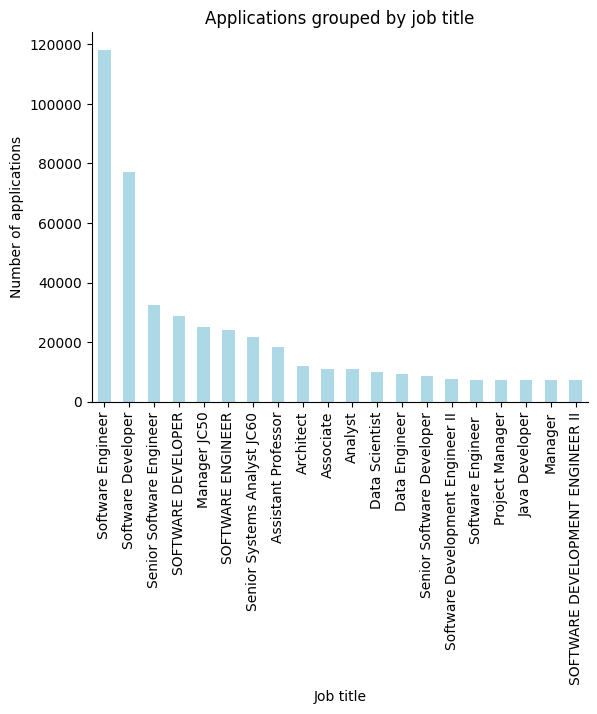

In [15]:
jobtitle =raw_data['job_title'].value_counts().sort_values(ascending=False)
print("Number of job titles\n",jobtitle)

ax = jobtitle.head(20).plot(kind='bar', stacked=True, title='Applications grouped by job title', color='lightblue')
ax.set_xlabel("Job title")
ax.set_ylabel('Number of applications')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


Number of applications grouped by year:

 year
2020    674582
2021    658472
2022    643279
2023    500509
2019    109469
Name: count, dtype: int64


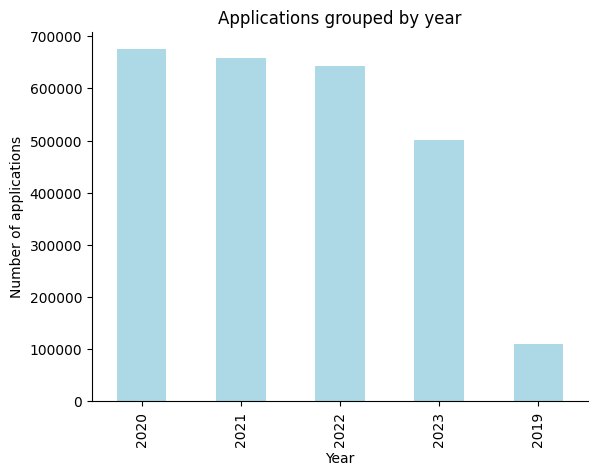

In [16]:
year = raw_data['year'].value_counts()
print('\nNumber of applications grouped by year:\n\n', year)


ax = year.head(10).plot(kind='bar', stacked=True, title='Applications grouped by year', color='lightblue')
ax.set_xlabel("Year")
ax.set_ylabel('Number of applications')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

case_status
Certified    2570957
Denied         15354
Name: count, dtype: int64


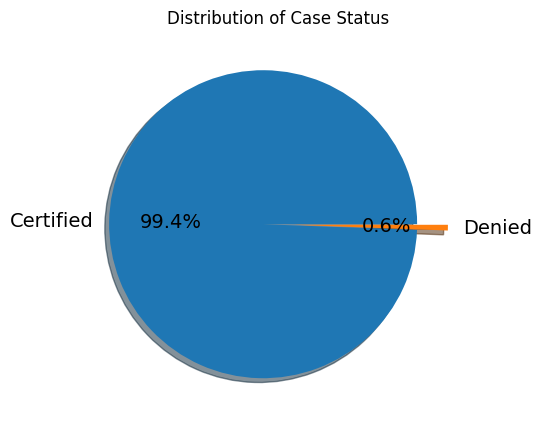

In [17]:
status = raw_data['case_status'].value_counts()
print(status)

status_filtered = status[:]

plt.figure(figsize=(10, 5))
plt.pie(x=status_filtered, labels=status_filtered.index, explode=[0.1] * len(status_filtered), autopct='%.1f%%', shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Case Status')
plt.show()

In [18]:
filtered_dataset = raw_data[raw_data['case_status'] == 'Certified']
jobtitle_counts = filtered_dataset['job_title'].value_counts()
jobtitles_to_keep = jobtitle_counts.index[jobtitle_counts >= 4000]
final_dataset = filtered_dataset[filtered_dataset['job_title'].isin(jobtitles_to_keep)]

In [19]:
remaining_data = raw_data[raw_data['case_status'] != 'Certified']
combined_data = pd.concat([remaining_data, final_dataset], ignore_index=True)

case_status
Certified    616455
Denied        15354
Name: count, dtype: int64


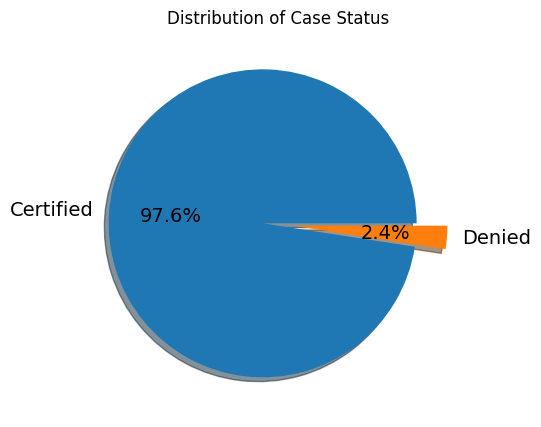

In [20]:
status = combined_data['case_status'].value_counts()
print(status)

status_filtered = status[:]
# Create a pie chart
plt.figure(figsize=(10, 5))
plt.pie(x=status_filtered, labels=status_filtered.index, explode=[0.1] * len(status_filtered), autopct='%.1f%%', shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Case Status')
plt.show()

In [17]:
combined_data.shape

(631809, 15)

In [18]:
combined_data.nunique()

id                        631809
case_status                    2
visa_class                     4
job_title                   6777
soc_code                     955
soc_title                    799
full_time_position             2
total_worker_positions        53
employer_name              47825
employer_state                56
employer_postal_code        8038
naics_code                  1591
worksite_state                55
worksite_postal_code       11912
year                           5
dtype: int64

In [19]:
combined_data  = combined_data.drop('id',axis=1)

In [20]:
combined_data.head(5)

,case_status,visa_class,job_title,soc_code,soc_title,full_time_position,total_worker_positions,employer_name,employer_state,employer_postal_code,naics_code,worksite_state,worksite_postal_code,year
0,Denied,H-1B,OPERATIONS RESEARCH ANALYST,15-2031.00,Operations Research Analysts,N,1,MEDCAPITAL SOLUTIONS LLC,CA,90015,522291,CA,90015,2020
1,Denied,H-1B,MECHANICAL ENGINEER,17-2141.00,Mechanical Engineers,Y,1,MAKERGEAR LLC,OH,44122,333249,OH,44122,2020
2,Denied,H-1B,Bookkeeper,43-3031.00,"Bookkeeping, Accounting, and Auditing Clerks",Y,1,LED Emerge LLC,TX,75220,339950,TX,75220,2020
3,Denied,H-1B,Producer,27-2012.01,Producers,Y,1,"Time Entertainment Group, Inc.",NY,10018,711320,NY,10018,2020
4,Denied,H-1B,MECHANICAL DRAFTER,17-3013.00,Mechanical Drafters,Y,1,EXELIQ CONSULTING & DESIGN LLC,CA,91790,541330,CA,91790,2020


In [21]:
from category_encoders import BinaryEncoder
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

In [22]:
outcome_raw = combined_data['case_status']
features_raw = combined_data.drop(['case_status'], axis = 1)

In [23]:
cat_columns = [col for col in features_raw.columns if features_raw[col].dtype == 'object']

In [24]:
outcome_raw = outcome_raw.apply(lambda x: 1 if x == 'Certified' else x)
outcome = outcome_raw.apply(lambda x: 2 if x == 'Denied' else x)
num_columns = [col for col in features_raw.columns if features_raw[col].dtype != 'object']
scaler = MinMaxScaler()
features_raw[num_columns] = scaler.fit_transform(features_raw[num_columns])
encoder = BinaryEncoder(cols= cat_columns)
feature_encoded = encoder.fit_transform(features_raw)

X_train, X_test, y_train, y_test = train_test_split(feature_encoded, outcome, test_size=0.25, random_state=42)

In [31]:
features_raw.columns

Index(['visa_class', 'job_title', 'soc_code', 'soc_title',
       'full_time_position', 'total_worker_positions', 'employer_name',
       'employer_state', 'employer_postal_code', 'naics_code',
       'worksite_state', 'worksite_postal_code', 'year'],
      dtype='object')

In [25]:
adasyn  = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)


In [26]:
final_data = pd.concat([X_resampled,y_resampled],axis=1)

case_status
2    465017
1    462321
Name: count, dtype: int64


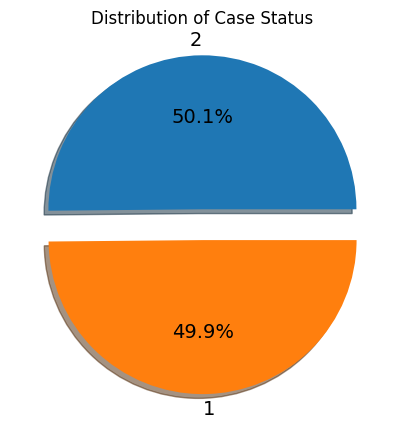

In [27]:
status = final_data['case_status'].value_counts()
print(status)
# Filter out the last three categories
status_filtered = status[:]
# Create a pie chart
plt.figure(figsize=(10, 5))
plt.pie(x=status_filtered, labels=status_filtered.index, explode=[0.1] * len(status_filtered), autopct='%.1f%%', shadow=True, textprops={'fontsize': 14})
plt.title('Distribution of Case Status')
plt.show()

In [29]:
print(X_resampled.shape)
print(y_resampled.shape)

(927338, 96)
(927338,)


In [ ]:
final_features = pd.concat([X_resampled,X_test],axis=0)
final_outcomes = pd.concat([y_resampled,y_test],axis=0)

In [ ]:
final_outcomes.shape

(1085291,)

In [ ]:
final_data = pd.concat([final_features,final_outcomes],axis=1)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(final_features, final_outcomes, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Model building

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. GPU will be used for training.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. CPU will be used for training.")


CUDA is available. GPU will be used for training.


In [ ]:
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [ ]:
#data building
X_train_numpy = X_train.values.astype(np.float32)
y_train_numpy = y_train.values.astype(np.int64)  # Use np.int64 or np.int32
X_test_numpy = X_test.values.astype(np.float32)
y_test_numpy = y_test.values.astype(np.int64)   # Use np.int64 or np.int32
X_val_numpy  = X_val.values.astype(np.float32)
y_val_numpy  = y_val.values.astype(np.int64)
y_train_numpy -= 1
y_test_numpy -= 1
y_val_numpy -=1
# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_numpy, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_numpy, dtype=torch.long)  # Assuming y_train contains class labels
X_test_tensor = torch.tensor(X_test_numpy, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_numpy, dtype=torch.long) 

X_val_tensor = torch.tensor(X_val_numpy, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_numpy, dtype=torch.long)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset  = TensorDataset(X_val_tensor,y_val_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)



In [ ]:
#model architecture
class H1BModel(nn.Module):
    def __init__(self,input_dim):
        super(H1BModel,self).__init__()

        self.layer1 = nn.Linear(input_dim,512)
        self.relu1 = nn.ReLU()
        self.dropout1  = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(512)

        self.layer2 = nn.Linear(512,256)
        self.relu2 = nn.ReLU()
        self.dropout2  = nn.Dropout(0.5)
        self.batchnorm2 = nn.BatchNorm1d(256)

        self.layer3 = nn.Linear(256,128)
        self.relu3 = nn.ReLU()
        self.dropout3  = nn.Dropout(0.5)
        self.batchnorm3 = nn.BatchNorm1d(128)

        self.layer4 = nn.Linear(128,2)

    def forward(self, x):
        
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)

        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)

        x = self.layer3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.batchnorm3(x)

        x = self.layer4(x)

        return x


In [ ]:
model = H1BModel(input_dim=X_test_tensor.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001,amsgrad=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    train_loss /= len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    
    # Print training and validation results
    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Step the scheduler with the validation loss
    scheduler.step(val_loss)

Epoch 1, Training Loss: 0.1285, Validation Loss: 0.0562, Validation Accuracy: 98.24%
Epoch 2, Training Loss: 0.0909, Validation Loss: 0.0497, Validation Accuracy: 98.30%
Epoch 3, Training Loss: 0.0808, Validation Loss: 0.0420, Validation Accuracy: 98.73%
Epoch 4, Training Loss: 0.0750, Validation Loss: 0.0409, Validation Accuracy: 98.66%
Epoch 5, Training Loss: 0.0720, Validation Loss: 0.0421, Validation Accuracy: 98.81%
Epoch 6, Training Loss: 0.0676, Validation Loss: 0.1353, Validation Accuracy: 98.81%
Epoch 7, Training Loss: 0.0613, Validation Loss: 0.1022, Validation Accuracy: 98.97%
Epoch 8, Training Loss: 0.0607, Validation Loss: 2.3130, Validation Accuracy: 98.89%
Epoch 9, Training Loss: 0.0586, Validation Loss: 3.5184, Validation Accuracy: 98.96%
Epoch 10, Training Loss: 0.0570, Validation Loss: 1.3831, Validation Accuracy: 99.01%
Epoch 11, Training Loss: 0.0537, Validation Loss: 104.3003, Validation Accuracy: 98.91%
Epoch 12, Training Loss: 0.0538, Validation Loss: 1.7770, Val

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)
model.eval()  # Set the model to evaluation mode

test_loss = 0
correct = 0
all_preds = []
all_targets = []

with torch.no_grad():  
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)  
        output = model(data)  # Forward pass
        test_loss += criterion(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        all_preds.extend(pred.view(-1).cpu().numpy())  # Store predictions
        all_targets.extend(target.view(-1).cpu().numpy())  # Store true labels

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)

# Calculating precision, recall, and F1-score
precision = precision_score(all_targets, all_preds, average='macro')
recall = recall_score(all_targets, all_preds, average='macro')
f1 = f1_score(all_targets, all_preds, average='macro')

print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


Test set: Average loss: 0.2506, Accuracy: 161195/162794 (99%)
Precision: 0.9897, Recall: 0.9903, F1 Score: 0.9900
